
# 🧠 Unsupervised Learning Analysis – PCA & Clustering on USArrests Dataset

This notebook performs an in-depth **Principal Component Analysis (PCA)** and **clustering** using the *USArrests* dataset.

---



## Step 1: Import Libraries and Load Dataset
We start by importing the necessary Python libraries and loading the `UsArrests.csv` dataset.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Load dataset
df = pd.read_csv('UsArrests.csv')
df.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6



## Step 2: Data Exploration and Preprocessing

PCA is sensitive to the scale of the variables. Therefore, we standardize the dataset before performing PCA.
We also check for missing values and basic statistics.


In [2]:

# Basic info and descriptive statistics
print(df.info())
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Standardize data (excluding the 'City' column)
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000

Missing values per column:
City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int


## Step 3: Correlation Analysis

We explore the relationships between features using a correlation heatmap. Strong correlations suggest redundancy that PCA can reduce.


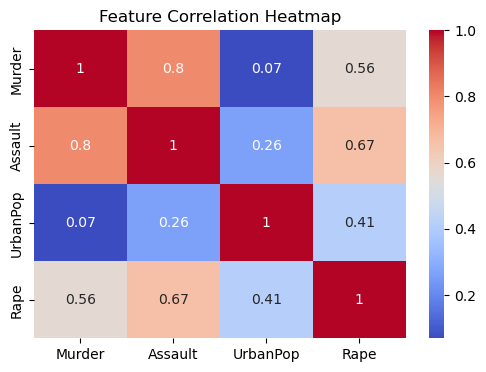

In [3]:

corr_matrix = X.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()



**Interpretation:**
- `Murder`, `Assault`, and `Rape` are strongly positively correlated.
- `UrbanPop` shows weaker correlations with crime variables.
- PCA will help eliminate redundancy between correlated features.



## Step 4: PCA Implementation

apply PCA to the standardized data and calculate the explained variance ratios.


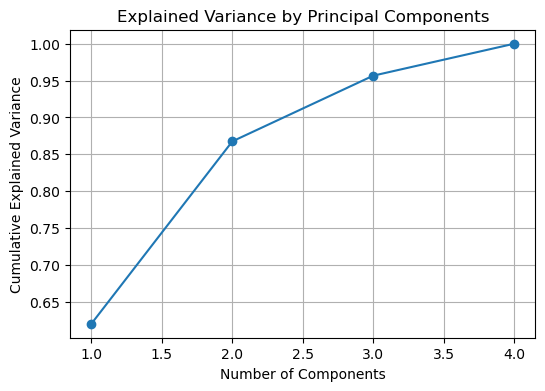

PC1: 0.6201
PC2: 0.2474
PC3: 0.0891
PC4: 0.0434


In [4]:

pca = PCA()
pca_data = pca.fit_transform(X_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f}")



## Step 5: Biplot of the First Two Principal Components

We visualize the data and feature loadings in a **biplot** to interpret how each feature contributes to the first two principal components.


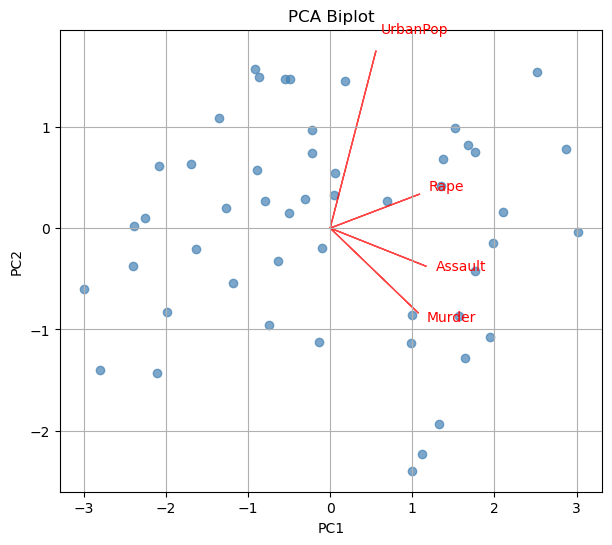

In [5]:

def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    plt.figure(figsize=(7,6))
    plt.scatter(xs, ys, c='steelblue', alpha=0.7)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2, color='r', alpha=0.7)
        plt.text(coeff[i,0]*2.2, coeff[i,1]*2.2, labels[i], color='r')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.show()

biplot(pca_data, pca.components_.T, labels=features)



**Interpretation:**
- The direction and length of the red arrows indicate the influence of each variable.
- `Assault` and `Murder` point in a similar direction, confirming their correlation.
- States with high values along PC1 tend to have higher crime rates overall.



## Step 6: Selecting the Number of Principal Components



In [6]:

explained = pca.explained_variance_ratio_ * 100
cum_var = np.cumsum(explained)
pca_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained))],
    'Explained Variance (%)': explained.round(2),
    'Cumulative Variance (%)': cum_var.round(2)
})
pca_table


,Principal Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,62.01,62.01
1,PC2,24.74,86.75
2,PC3,8.91,95.66
3,PC4,4.34,100.00


Interpretation
- **PC1** explains over **62% of total variability**, showing that most differences among states can be summarized by one major dimension.  
- Adding **PC2** increases the cumulative variance to **~87%**, capturing almost all meaningful structure in the data.  
- **PC3** and **PC4** contribute little additional information (~13%), representing smaller or residual patterns.

###  Decision
will retain **two principal components (PC1 and PC2)** for further analysis, as they preserve **86.75% of total variance** while simplifying the data for clustering and visualization.


## Step 7: Clustering Analysis

We apply **K-Means** and **Hierarchical Clustering** to identify patterns in the PCA-transformed data.


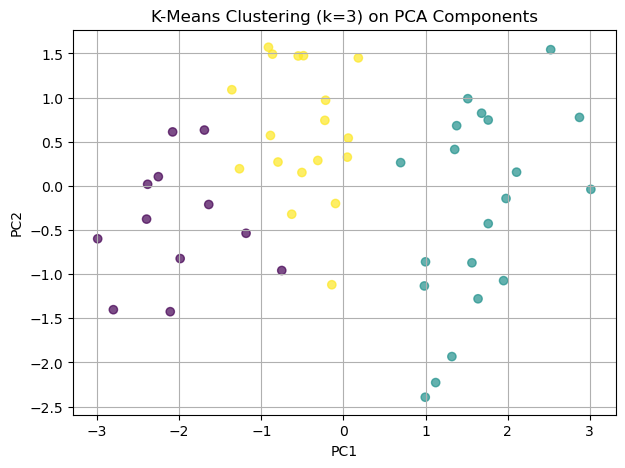

In [7]:

# Use two principal components for clustering
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_scaled)

# ---- K-Means ----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering (k=3) on PCA Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

df['KMeans_Cluster'] = clusters_kmeans


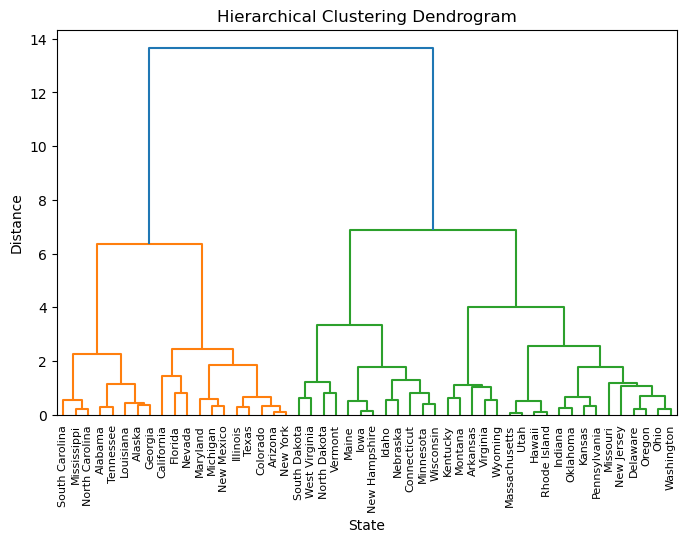

In [8]:

# ---- Hierarchical Clustering ----
Z = linkage(X_pca, method='ward')
plt.figure(figsize=(8,5))
dendrogram(Z, labels=df['City'].values, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

df['HierCluster'] = fcluster(Z, 3, criterion='maxclust')



## 🧩 Summary

- PCA reduced the dataset to **two principal components**, preserving **~87%** of the variance.  
- Correlation analysis showed redundancy among violent crime variables.  
- Clustering revealed three distinct state groups based on crime profiles.  
- The combination of PCA and clustering provides strong insights into regional crime patterns.
